In [17]:
import pandas as pd
df = pd.read_csv('output.csv')
df.head(5)

df_clean = df.dropna(subset=['rooms', 'area'])
df_clean = df_clean[(df_clean['rooms'] > 0) & (df_clean['area'] > 0)]

df_clean["price_per_sqm"] = (df_clean["price"] / df_clean["area"]).round(2)
df_clean.head()

,id,price,district,rooms,area,seller_type,price_per_sqm
0,1,1199000.0,Grunwald,3.0,63.54,Oferta prywatna,18870.00
1,2,405000.0,Stare Miasto,2.0,30.00,Oferta prywatna,13500.00
2,3,679000.0,Stare Miasto,4.0,64.90,Oferta prywatna,10462.25
3,4,425000.0,Stare Miasto,1.0,29.20,Biuro nieruchomości,14554.79
4,5,650000.0,Stare Miasto,3.0,53.00,Oferta prywatna,12264.15


# Linear regression MODEL

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Mapping district distances from the city centre (in km)
district_distances = {
    'Jeżyce': 3.5,
    'Wilda': 4.0,
    'Nowe Miasto': 2.5,
    'Stare Miasto': 0.5,
    'Grunwald': 5.0,
    'Łazarz': 3.0,
}
df_clean['distance_km'] = df_clean['district'].map(district_distances)

# Dropping rows with missing values in important columns
df_clean = df_clean[['rooms', 'area', 'seller_type', 'district', 'price', 'distance_km']].dropna()

# Converting district into binary columns to use in regression
df_encoded = pd.get_dummies(df_clean, columns=['district'], drop_first=True)

# Adding polynomial term for area (area squared)  -- modification of the linear model
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_area = poly.fit_transform(df_encoded[['area']])
df_encoded['area'] = poly_area[:, 0] 
df_encoded['area_sq'] = poly_area[:, 1] 

# Adding interaction terms between area and districts -- modification of the linear model
district_cols = [col for col in df_encoded.columns if col.startswith('district_')]

for col in district_cols:
    df_encoded[f'area_{col}'] = df_encoded['area'] * df_encoded[col]

feature_cols = ['area', 'area_sq', 'distance_km'] + district_cols + [f'area_{col}' for col in district_cols]

X = df_encoded[feature_cols]
y = df_encoded['price']



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=48
)
# Scaling features to standardize the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


# Fitting linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cv = (rmse * 100 / np.mean(y)).round(2)

print(f"Coefficient of variation: {cv}%")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


# Coefficients and intercept
coefficients = pd.Series(model.coef_, index=feature_cols)
print("Coefficients:")
print((coefficients.sort_values(ascending=False)).round(2))

intercept = model.intercept_
print(f"Intercept: {intercept:.2f}")


# Variable relevance
import statsmodels.api as sm

# Converting boolean columns to int for statsmodels compatibility
X_sm_int = sm.add_constant(X.astype(float))
model_sm = sm.OLS(y, X_sm_int).fit()
print(model_sm.summary())


Coefficient of variation: 18.65%
Root Mean Squared Error: 111029.73
R^2 Score: 0.81
Coefficients:
area                          237380.55
area_district_Nowe Miasto     187671.37
district_Stare Miasto          80750.19
area_district_Jeżyce           67395.46
area_district_Wilda            25830.19
distance_km                    23497.90
district_Wilda                -10783.84
district_Jeżyce               -34019.47
area_district_Stare Miasto    -34674.28
area_sq                       -60030.06
district_Nowe Miasto         -176981.86
dtype: float64
Intercept: 596502.17
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     283.3
Date:                Mon, 27 Oct 2025   Prob (F-statistic):          5.93e-199
Time:                        13

# TESTING THE MODEL 1

In [20]:
from statsmodels.stats.stattools import durbin_watson

from scipy.stats import pearsonr


residuals = model_sm.resid

# Lagged residuals (shift by 1)
residuals_lagged = residuals.shift(1)

# Drop the first NA (because of lag)
valid_idx = residuals_lagged.notna()

# Calculate Pearson correlation between residuals and lagged residuals
corr, p_value = pearsonr(residuals[valid_idx], residuals_lagged[valid_idx])

print(f"Pearson correlation between residuals and their lagged values: {corr:.3f}")
print(f"P-value: {p_value:.4e}")

# Calculate the number of regressors (k)
k = X_sm_int.shape[1] - 1  # subtract 1 for intercept
print(f"Number of regressors (k): {k}")

# Calculate the Durbin-Watson statistic
dw_stat = durbin_watson(model_sm.resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")

Pearson correlation between residuals and their lagged values: 0.060
P-value: 1.7539e-01
Number of regressors (k): 11
Durbin-Watson statistic: 1.809


## AUTOCORRELATION OF THE RESIDUALS

Pearson correlation suggests that the residuals are not correlated. P-value is > than 0.05 so I cannot reject the null hypothesis of autocorrelation. 

The Durbin-Watson statistic (1.809) also points to autocorrelation.

# Overall

There is some autocorrelation of the residuals in the model.

# TESTING THE MODEL 2

Testing for heteroscedasticity

White’s test for heteroskedasticity (train data):
{'Test Statistic': np.float64(121.65312735897534), 'Test Statistic p-value': np.float64(1.4079424180642205e-16), 'F-Statistic': np.float64(8.21331601444815), 'F-Test p-value': np.float64(4.967319207332269e-20)}


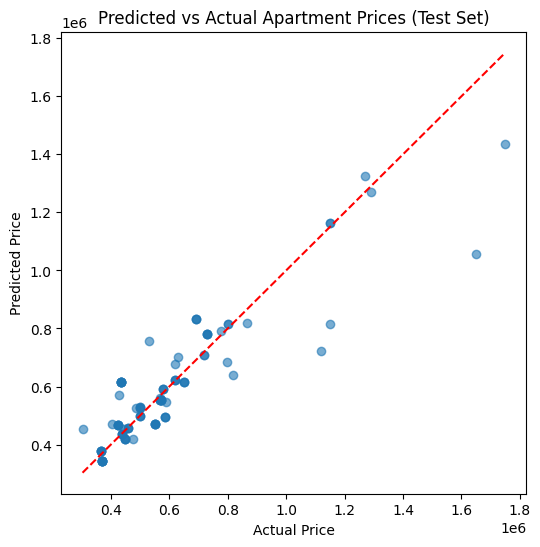

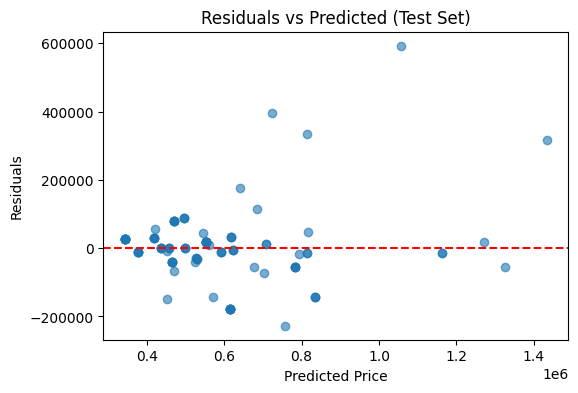

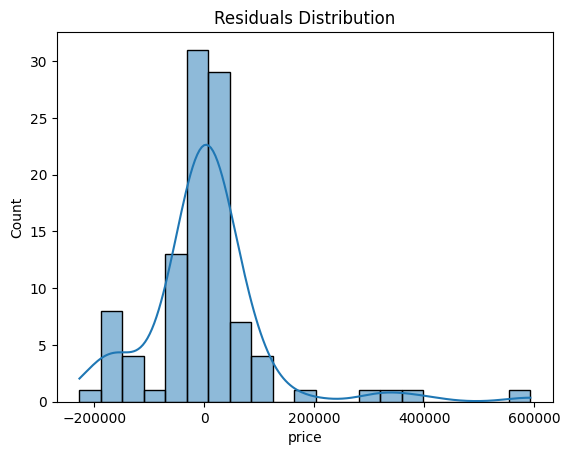

In [21]:
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import het_white

# Fit linear regression model with statsmodels to get residuals and design matrix
X_sm = sm.add_constant(X_train_scaled)  # add intercept
model_sm = sm.OLS(y_train, X_sm).fit()

# Get residuals
residuals_train = model_sm.resid  # from statsmodels model (train only)
exog_train = model_sm.model.exog

white_test = het_white(residuals_train, exog_train)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

print("White’s test for heteroskedasticity (train data):")
print(dict(zip(labels, white_test)))

# Predicted vs Actual (on TEST data) 
y_pred = model.predict(X_test_scaled)  # use scaled test data if model trained on scaled
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Apartment Prices (Test Set)")
plt.show()

# Residuals vs Predicted (on TEST data)
residuals_test = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals_test, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Test Set)")
plt.show()

import seaborn as sns

sns.histplot(residuals_test, kde=True)
plt.title("Residuals Distribution")
plt.show()



## FIXING HETERSOSCEDASTICITY OF THE RESIDUALS

The linear model modified with interaction and polynomial terms show heteroscedasticity with White's test. I will attempt to correct it with WLS.

WLS-log model summary:
                            WLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.992
Model:                            WLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     4854.
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:52:36   Log-Likelihood:                -374.47
No. Observations:                 409   AIC:                             770.9
Df Residuals:                     398   BIC:                             815.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

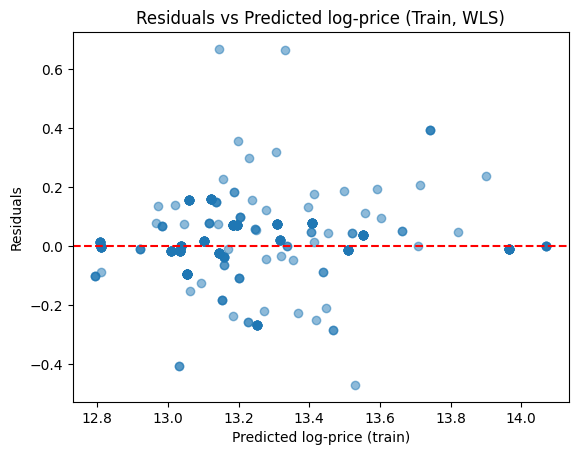

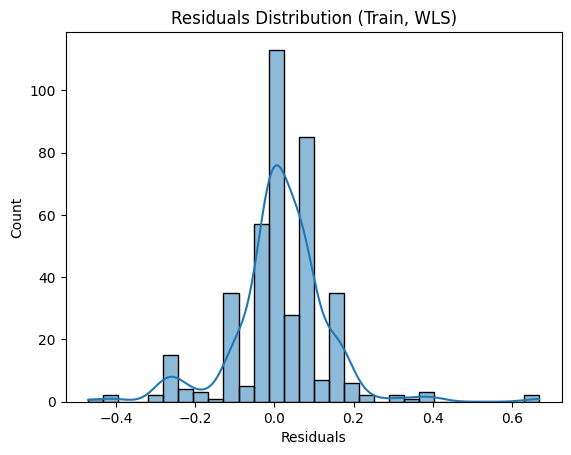

R² on log scale - train: 0.843, test: 0.820


In [23]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# 1. Train/test split

X = df_encoded[feature_cols]
y = df_encoded['price']

# Optional: scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=48)


# 2. Log-transform target (train only)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


# 3. Fit initial OLS on training log-price

X_train_sm = sm.add_constant(X_train)
ols_log = sm.OLS(y_train_log, X_train_sm).fit()
residuals_log = ols_log.resid


# 4. Estimate variance for WLS weights

residuals_log_sq = residuals_log ** 2
aux_model = sm.OLS(residuals_log_sq, X_train_sm).fit()
fitted_var = aux_model.fittedvalues
weights = 1 / np.maximum(fitted_var, 1e-6)  # avoid division by zero

# 5. Fit WLS on log-price

wls_log = sm.WLS(y_train_log, X_train_sm, weights=weights).fit()
print("WLS-log model summary:")
print(wls_log.summary())

# 6. Predict on train and test

# Train predictions
y_train_log_pred = wls_log.predict(X_train_sm)
y_train_pred = np.expm1(y_train_log_pred)

# Test predictions
X_test_sm = sm.add_constant(X_test)
y_test_log_pred = wls_log.predict(X_test_sm)
y_test_pred = np.expm1(y_test_log_pred)


# 7. Residuals

residuals_train = y_train_log - y_train_log_pred
residuals_test = y_test_log - y_test_log_pred


# 8. White test for heteroskedasticity (train)

white_test_wls = het_white(residuals_train, X_train_sm)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print("White's test (train WLS-log):", dict(zip(labels, white_test_wls)))


# 9. Residual plots

# Residuals vs predicted (train)
plt.scatter(y_train_log_pred, residuals_train, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log-price (train)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted log-price (Train, WLS)')
plt.show()

# Residuals histogram (train)
import seaborn as sns
sns.histplot(residuals_train, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Residuals Distribution (Train, WLS)')
plt.show()


# 10. R²

r2_train_log = r2_score(y_train_log, y_train_log_pred)
r2_test_log = r2_score(y_test_log, y_test_log_pred)
print(f"R² on log scale - train: {r2_train_log:.3f}, test: {r2_test_log:.3f}")


## RESULTS

The R-Squared has improved:

From WLS Model summary: R-squared: 0.992
R² on log scale - train: 0.843, test: 0.820

I used log-transformed price in order to compress the larger values and try to reduce heteroscedascity. Then I proceeded to use WLS on the log-price model. I tested the corrected model for heteroscedasticity with White's test. 
Despite the attempts at correcting the model, I still had to reject the null hypothesis of homoscedasticity (F-test p-value < 0.01). 

Heteroscedasticity casues the standard errors, confidence intervals, and significance tests to be unreliable.

The model is build using a limited set of variables, which do not fully capture the full range of factors contributing to price formation. As a result, the model might systematically under- or overpredict prices for certain segments of the data, especially at the extremes. 